# 1. Importação de Bibliotecas e carregamento de dados

## 1.1. Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from pathlib import Path

## 1.2. Carregamento de dados

In [2]:
df = pd.read_csv('data/raw/Obesity.csv')
#df = pd.read_csv('Obesity.csv')

In [3]:
print(df.head())

   Gender   Age  Height  Weight family_history FAVC  FCVC  NCP       CAEC  \
0  Female  21.0    1.62    64.0            yes   no   2.0  3.0  Sometimes   
1  Female  21.0    1.52    56.0            yes   no   3.0  3.0  Sometimes   
2    Male  23.0    1.80    77.0            yes   no   2.0  3.0  Sometimes   
3    Male  27.0    1.80    87.0             no   no   3.0  3.0  Sometimes   
4    Male  22.0    1.78    89.8             no   no   2.0  1.0  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS  \
0    no   2.0   no  0.0  1.0          no  Public_Transportation   
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation   
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation   
3    no   2.0   no  2.0  0.0  Frequently                Walking   
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation   

               Obesity  
0        Normal_Weight  
1        Normal_Weight  
2        Normal_Weight  
3   Overweight_Level_I  
4  Overwe

# 2. Tratamento dos dados

## 2.1. Checagem iniciais

In [4]:
# Verificação da quantidade de linhas e colunas
df.shape

(2111, 17)

In [5]:
# Verificação das informações do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

In [6]:
# Verificação de valores nulos
df.isnull().sum()

Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

## 2.2. Ajuste e padronização das features

In [7]:
# Renoemando colunas para facilitar a leitura e manipulação dos dados
df_tratado = df.rename(columns ={
    'Gender': 'genero',                                 # Male ou Female
    'Age': 'idade',                                     # Idade em anos
    'Height': 'altura',                                 # Altura em metros
    'Weight': 'peso',                                   # Peso em kg
    'family_history': 'historico_familiar_sobrepeso',   # Histórico familiar de sobrepeso? (yes, no)
    'FAVC': 'consumo_alimentos_caloricos',              # Consome frequentemente alimentos com alto teor calórico?
    'FCVC': 'consumo_vegetais',                         # Qual a frequência de consumo de vegetais? Escala de 1-raramente, 2-as_vezes,  3-sempre
    'NCP': 'refeicoes_por_dia',                         # Número de refeições por dia? Escala de 1-uma_refeicao_dia, 2-duas_refeicao_dia,  3  tres_refeicao_dia,  4-quatro_refeicao_dia
    'CAEC': 'lanches_entre_refeicoes',                  # Alimenta-se entre refeições? (nao, as_vezes, frequentemente, sempre)
    'SMOKE': 'fumante',                                 # Você é fumante? (yes, no)
    'CH2O': 'consumo_agua_por_dia',                     # Consumo de água por dia? Escala de 1 a 3
    'SCC': 'monitora_calorias',                         # Monitora o consumo de calorias? (yes, no)
    'FAF': 'atividade_fisica_semana',                   # Frequência de atividade física por semana? Escala de 0 a 3
    'TUE': 'tempo_eletronicos_por_dia',                 # Tempo gasto em dispositivos eletrônicos por dia? Escala de 0 a 2
    'CALC': 'consumo_alcoolico',                        # Consumo de bebidas alcoólicas? (no, sometimes, frequently, always)
    'MTRANS': 'meio_transporte',                        # Meio de transporte utilizado principalmente (automobile, bike, motorbike, public_transportation, walking)
    'Obesity': 'obesidade'                              # Nível de obesidade (Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III)
})

## 2.3. Verificação de conteúdo das features e ajustes

Numéricas: idade, altura (m), peso (kg) e IMC (feature criada = peso / altura²).
Ordinais (escalas): consumo_vegetais (1–3), refeicoes_por_dia (1–4), consumo_agua_por_dia (1–3), atividade_fisica_semana (0–3), tempo_eletronicos_por_dia (0–2).
Observação: o dicionário informa ruído com decimais nessas colunas; no tratamento foi arredondado para o inteiro mais próximo e travado nos limites das escalas. 
Categóricas: genero, historico_familiar_sobrepeso, consumo_alimentos_caloricos, lanches_entre_refeicoes, fumante, monitora_calorias, consumo_alcoolico, meio_transporte.
Alvo: obesidade (multiclasse: Peso_Insuficiente, Peso_Normal, Nivel_Sobrepeso_I/II, Tipo_Obesidade_I/II/III).

In [8]:
# Conferindo valores das features
df_tratado.nunique()

genero                             2
idade                           1402
altura                          1574
peso                            1525
historico_familiar_sobrepeso       2
consumo_alimentos_caloricos        2
consumo_vegetais                 810
refeicoes_por_dia                635
lanches_entre_refeicoes            4
fumante                            2
consumo_agua_por_dia            1268
monitora_calorias                  2
atividade_fisica_semana         1190
tempo_eletronicos_por_dia       1129
consumo_alcoolico                  4
meio_transporte                    5
obesidade                          7
dtype: int64

In [9]:
# Ajuste de valores das features conforme dicionário orienta.
df_tratado['consumo_vegetais']  = df_tratado['consumo_vegetais'].round(0).astype(int)
df_tratado['refeicoes_por_dia']  = df_tratado['refeicoes_por_dia'].round(0).astype(int)
df_tratado['consumo_agua_por_dia']  = df_tratado['consumo_agua_por_dia'].round(0).astype(int)
df_tratado['atividade_fisica_semana']  = df_tratado['atividade_fisica_semana'].round(0).astype(int)
df_tratado['tempo_eletronicos_por_dia']  = df_tratado['tempo_eletronicos_por_dia'].round(0).astype(int)

## 2.4. Binarização de features

In [10]:
# Padroniza yes/no e categorias
# Yes = 1 / No = 0
for col in ['historico_familiar_sobrepeso','consumo_alimentos_caloricos','fumante','monitora_calorias']:
    if col in df_tratado.columns:
        df_tratado[col] = df_tratado[col].map({'yes': 1, 'no': 0})
for col in ['lanches_entre_refeicoes','consumo_alcoolico','meio_transporte','genero']:
    if col in df_tratado.columns:
        df_tratado[col] = df_tratado[col].astype(str).str.strip()

In [11]:
# Binarização de gênero
df_tratado['genero'] = df_tratado['genero'].map({'Female': 0, 'Male': 1})

In [12]:
# Arredonda e limita escalas ordinais (ruído mencionado no dicionário)
for col, bounds in {'consumo_vegetais':(1,3),'refeicoes_por_dia':(1,4),'consumo_agua_por_dia':(1,3),'atividade_fisica_semana':(0,3),'tempo_eletronicos_por_dia':(0,2)}.items():
    if col in df_tratado.columns:
        df_tratado[col] = pd.to_numeric(df_tratado[col], errors='coerce').round().clip(bounds[0], bounds[1]).astype(int)

In [13]:
df_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   genero                        2111 non-null   int64  
 1   idade                         2111 non-null   float64
 2   altura                        2111 non-null   float64
 3   peso                          2111 non-null   float64
 4   historico_familiar_sobrepeso  2111 non-null   int64  
 5   consumo_alimentos_caloricos   2111 non-null   int64  
 6   consumo_vegetais              2111 non-null   int32  
 7   refeicoes_por_dia             2111 non-null   int32  
 8   lanches_entre_refeicoes       2111 non-null   object 
 9   fumante                       2111 non-null   int64  
 10  consumo_agua_por_dia          2111 non-null   int32  
 11  monitora_calorias             2111 non-null   int64  
 12  atividade_fisica_semana       2111 non-null   int32  
 13  tem

In [14]:
df_tratado.head()

,genero,idade,altura,peso,historico_familiar_sobrepeso,consumo_alimentos_caloricos,consumo_vegetais,refeicoes_por_dia,lanches_entre_refeicoes,fumante,consumo_agua_por_dia,monitora_calorias,atividade_fisica_semana,tempo_eletronicos_por_dia,consumo_alcoolico,meio_transporte,obesidade
0,0,21.0,1.62,64.0,1,0,2,3,Sometimes,0,2,0,0,1,no,Public_Transportation,Normal_Weight
1,0,21.0,1.52,56.0,1,0,3,3,Sometimes,1,3,1,3,0,Sometimes,Public_Transportation,Normal_Weight
2,1,23.0,1.80,77.0,1,0,2,3,Sometimes,0,2,0,2,1,Frequently,Public_Transportation,Normal_Weight
3,1,27.0,1.80,87.0,0,0,3,3,Sometimes,0,2,0,2,0,Frequently,Walking,Overweight_Level_I
4,1,22.0,1.78,89.8,0,0,2,1,Sometimes,0,2,0,0,0,Sometimes,Public_Transportation,Overweight_Level_II


# 3. Modelos - Acurácia

In [15]:
# Feature engineering: IMC
df_tratado['IMC'] = (df_tratado['peso'] / (df_tratado['altura']**2)).round(2)
df_tratado.head()

,genero,idade,altura,peso,historico_familiar_sobrepeso,consumo_alimentos_caloricos,consumo_vegetais,refeicoes_por_dia,lanches_entre_refeicoes,fumante,consumo_agua_por_dia,monitora_calorias,atividade_fisica_semana,tempo_eletronicos_por_dia,consumo_alcoolico,meio_transporte,obesidade,IMC
0,0,21.0,1.62,64.0,1,0,2,3,Sometimes,0,2,0,0,1,no,Public_Transportation,Normal_Weight,24.39
1,0,21.0,1.52,56.0,1,0,3,3,Sometimes,1,3,1,3,0,Sometimes,Public_Transportation,Normal_Weight,24.24
2,1,23.0,1.80,77.0,1,0,2,3,Sometimes,0,2,0,2,1,Frequently,Public_Transportation,Normal_Weight,23.77
3,1,27.0,1.80,87.0,0,0,3,3,Sometimes,0,2,0,2,0,Frequently,Walking,Overweight_Level_I,26.85
4,1,22.0,1.78,89.8,0,0,2,1,Sometimes,0,2,0,0,0,Sometimes,Public_Transportation,Overweight_Level_II,28.34


In [16]:
# Split
target = 'obesidade'
X = df_tratado.drop(columns=[target])
y = df_tratado[target]

In [17]:
# Pré-processamento
num_features = ['idade','altura','peso', 'IMC','consumo_vegetais','refeicoes_por_dia','consumo_agua_por_dia','atividade_fisica_semana','tempo_eletronicos_por_dia']
num_features = [c for c in num_features if c in X.columns]
cat_features = [c for c in X.columns if c not in num_features]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

In [18]:
# Modelos
models = {
    'logreg': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(random_state=42, n_estimators=300, n_jobs=-1),
    'gb': GradientBoostingClassifier(random_state=42)
}
pipelines = {name: Pipeline([('preprocess', preprocess), ('model', m)]) for name, m in models.items()}

In [19]:
# Treino/validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    results[name] = {
        'accuracy': accuracy_score(y_test, pred),
        'report': classification_report(y_test, pred, output_dict=True)
    }

In [20]:
# Melhor modelo
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_pipeline = pipelines[best_model_name]
best_acc = results[best_model_name]['accuracy']

print(best_acc)

0.983451536643026


# 4. Gráficos

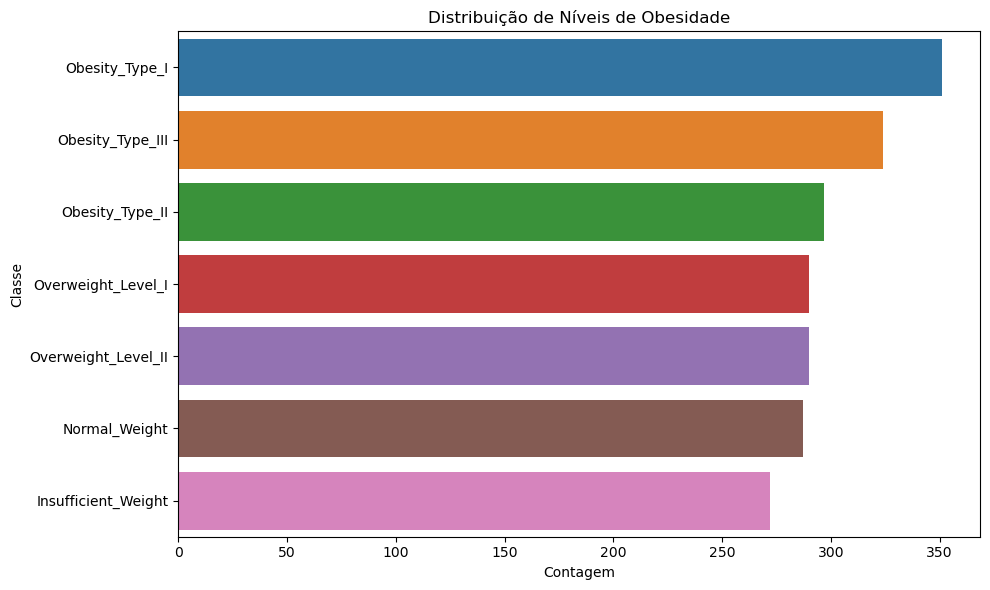

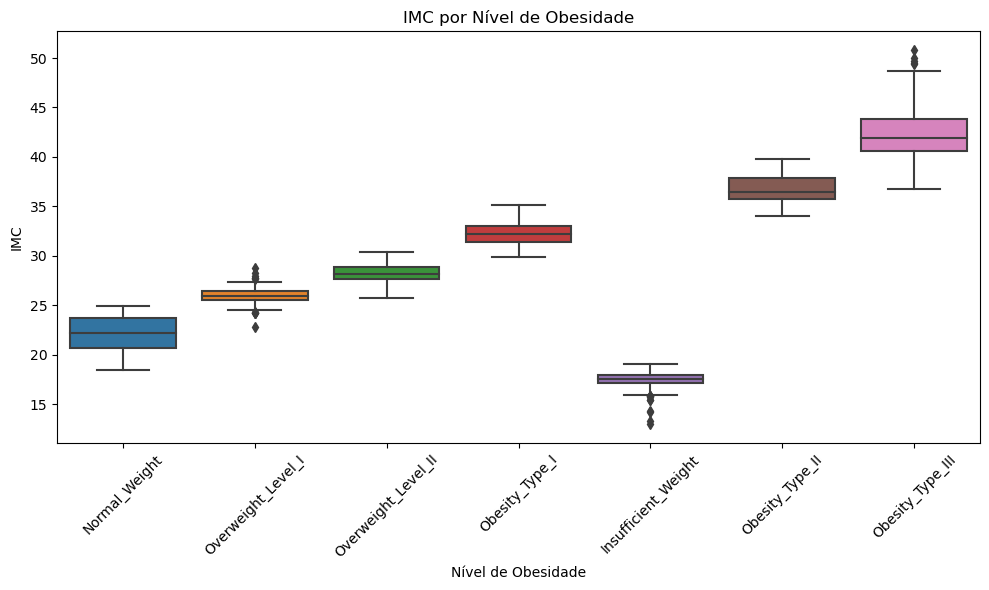

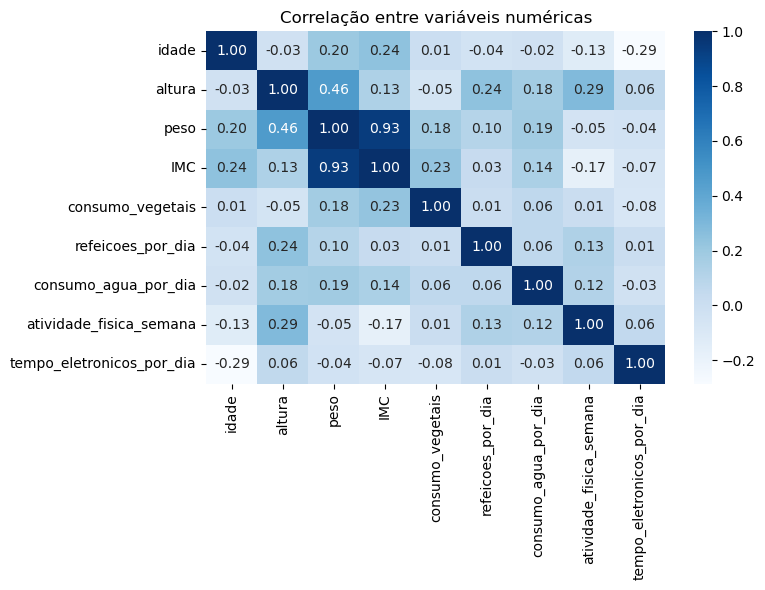

In [21]:
# Gráficos analíticos
os.makedirs('figures', exist_ok=True)
plt.figure(figsize=(10,6))
sns.countplot(y=df_tratado[target], order=df_tratado[target].value_counts().index)
plt.title('Distribuição de Níveis de Obesidade')
plt.xlabel('Contagem'); plt.ylabel('Classe')
plt.tight_layout(); plt.savefig('figures/01_distribuicao_classes.png'); plt.show(); plt.close()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_tratado, x=target, y='IMC')
plt.xticks(rotation=45)
plt.title('IMC por Nível de Obesidade')
plt.ylabel('IMC'); plt.xlabel('Nível de Obesidade')
plt.tight_layout(); plt.savefig('figures/02_imc_por_classe.png'); plt.show(); plt.close()

if len(num_features) > 1:
    corr = df_tratado[num_features].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Correlação entre variáveis numéricas')
    plt.tight_layout(); plt.savefig('figures/03_correlacao_numericas.png'); plt.show(); plt.close()

# Importâncias (se RF for melhor)
if best_model_name == 'rf':
    ohe = best_pipeline.named_steps['preprocess'].named_transformers_['cat']
    ohe_features = list(ohe.get_feature_names_out(cat_features))
    all_features = num_features + ohe_features
    rf = best_pipeline.named_steps['model']
    imp = rf.feature_importances_
    imp_df = pd.DataFrame({'feature': all_features, 'importance': imp}).sort_values('importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(data=imp_df.head(15), x='importance', y='feature')
    plt.title('Top 15 Features - Importância (RandomForest)')
    plt.tight_layout(); plt.savefig('figures/04_importancias_rf.png'); plt.show(); plt.close()
    imp_df.to_csv('figures/04_importancias_rf_full.csv', index=False)

In [22]:
# =====================
# Exibir na tela
# =====================
SHOW = True  # coloque False se quiser apenas salvar as figuras

def save_and_show(path, dpi=160):
    """Salva a figura atual e, se SHOW=True, exibe na tela."""
    plt.tight_layout()
    plt.savefig(path, dpi=dpi)
    if SHOW:
        plt.show()
    plt.close()

# =====================
# Configurações gerais
# =====================
plt.rcParams['figure.figsize'] = (9, 5.5)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.size'] = 11

# Pasta de saída
out = Path('figs_insights')
out.mkdir(exist_ok=True)


# Remover NAs essenciais
df_tratado = df_tratado.dropna(subset=['idade','altura','peso','consumo_vegetais','refeicoes_por_dia',
                                       'consumo_agua_por_dia','atividade_fisica_semana','tempo_eletronicos_por_dia','obesidade'])


# Define os intervalos de IMC (em pontos de corte) para as classes
bins = [0,18.5,25,30,35,40,np.inf]
labels_faixa = ['Underweight','Normal','Overweight','Obesity_I','Obesity_II','Obesity_III']
df_tratado['IMC_Classe_Faixa'] = pd.cut(df_tratado['IMC'], bins=bins, labels=labels_faixa, right=False)

# Harmoniza os rótulos da base para comparar com a OMS
map_target_simple = {
    'Insufficient_Weight':'Underweight',
    'Normal_Weight':'Normal',
    'Overweight_Level_I':'Overweight',
    'Overweight_Level_II':'Overweight',
    'Obesity_Type_I':'Obesity_I',
    'Obesity_Type_II':'Obesity_II',
    'Obesity_Type_III':'Obesity_III'
}
df_tratado['Obesidade_Simplificada'] = df_tratado['obesidade'].map(map_target_simple)

# Flags principais
df_tratado['is_obeso'] = df_tratado['obesidade'].isin(['Obesity_Type_I','Obesity_Type_II','Obesity_Type_III'])
df_tratado['is_sobrepeso'] = df_tratado['obesidade'].isin(['Overweight_Level_I','Overweight_Level_II'])
df_tratado['is_normal'] = df_tratado['obesidade'].isin(['Normal_Weight','Insufficient_Weight'])

# =====================
# 1) Visão geral
# =====================
N = len(df_tratado)
P_obeso = df_tratado['is_obeso'].mean()*100
P_sobrepeso = df_tratado['is_sobrepeso'].mean()*100
P_normal = df_tratado['is_normal'].mean()*100

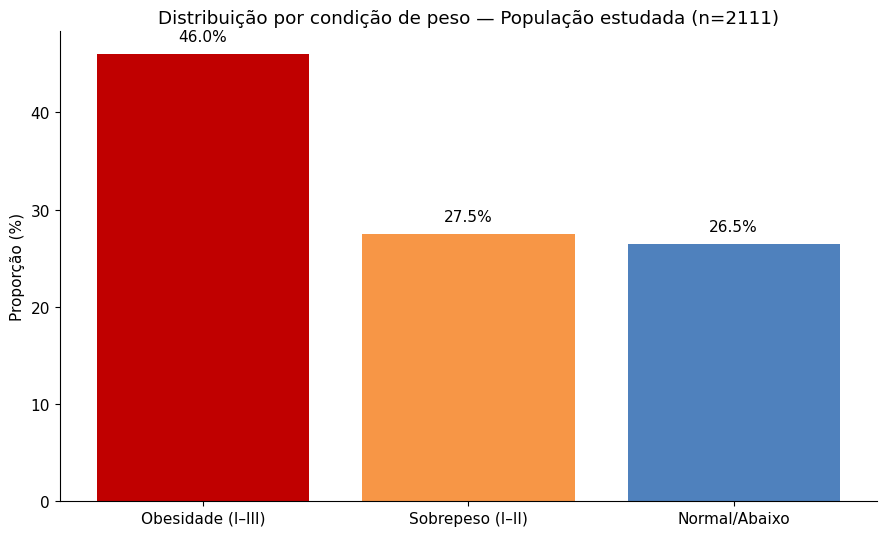

In [23]:
# Distribuição global
fig, ax = plt.subplots()
ax.bar(['Obesidade (I–III)','Sobrepeso (I–II)','Normal/Abaixo'],
       [P_obeso, P_sobrepeso, P_normal], color=['#C00000','#F79646','#4F81BD'])
ax.set_title('Distribuição por condição de peso — População estudada (n={})'.format(N))
ax.set_ylabel('Proporção (%)')
for i,v in enumerate([P_obeso,P_sobrepeso,P_normal]):
    ax.text(i, v+1, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)
save_and_show(out/'01_distribuicao_geral.png')

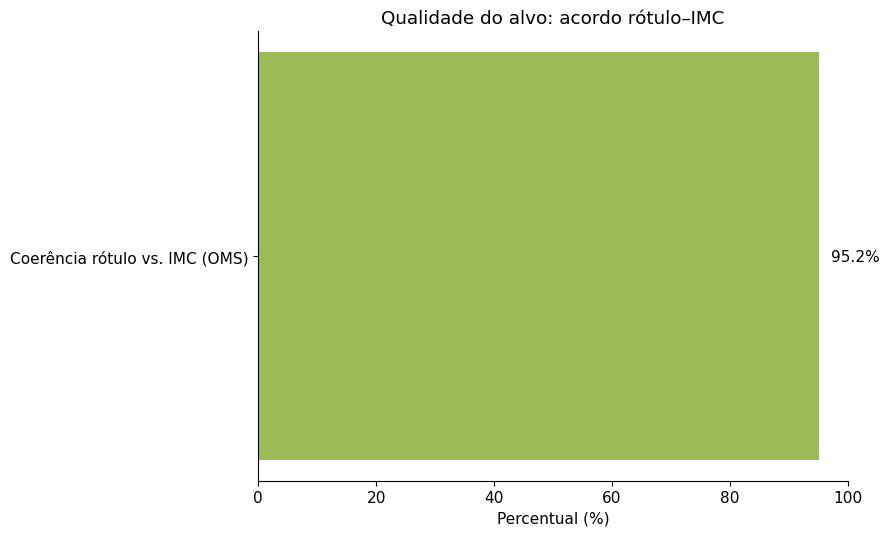

In [24]:
# Coerência rótulo vs. IMC
agreement = (df_tratado['IMC_Classe_Faixa'].astype(str) == df_tratado['Obesidade_Simplificada'].astype(str)).mean()*100
fig, ax = plt.subplots()
ax.barh(['Coerência rótulo vs. IMC (OMS)'], [agreement], color='#9BBB59')
ax.set_xlim(0,100)
ax.set_xlabel('Percentual (%)')
ax.set_title('Qualidade do alvo: acordo rótulo–IMC')
for v in [agreement]:
    ax.text(v+2, 0, f"{v:.1f}%", va='center')
save_and_show(out/'02_acordo_rotulo_imc.png')

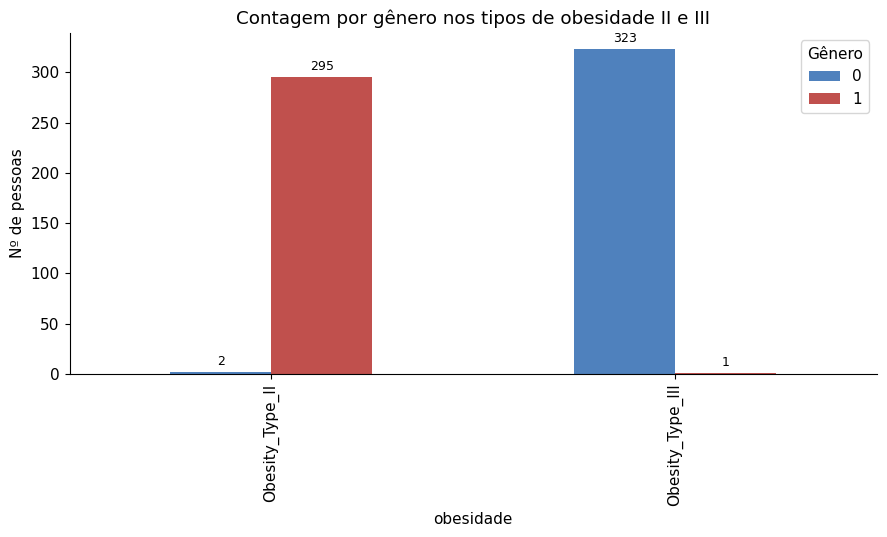

In [25]:
# Diferenças por gênero (Obesidade Tipo II e III)
focus = df_tratado[df_tratado['obesidade'].isin(['Obesity_Type_II','Obesity_Type_III'])]
ct = focus.groupby(['obesidade','genero']).size().unstack(fill_value=0)
fig, ax = plt.subplots()
ct.plot(kind='bar', ax=ax, color=['#4F81BD','#C0504D'])
ax.set_title('Contagem por gênero nos tipos de obesidade II e III')
ax.set_ylabel('Nº de pessoas')
ax.legend(title='Gênero')
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
save_and_show(out/'03_genero_obesidade_II_III.png')

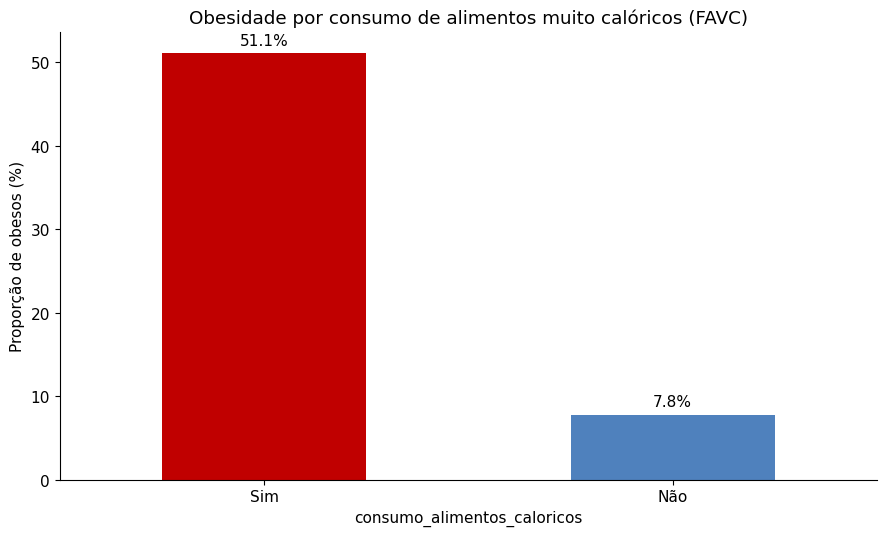

In [26]:
# =====================
# 2) Fatores associados (proporção de obesos)
# =====================
# Consumo de Alimentos Calóricos
favc = df_tratado.groupby('consumo_alimentos_caloricos')['is_obeso'].mean()*100
fig, ax = plt.subplots()
favc.reindex([1, 0]).rename({1:'Sim', 0:'Não'}).plot(kind='bar', ax=ax, color=['#C00000','#4F81BD'])
ax.set_title('Obesidade por consumo de alimentos muito calóricos (FAVC)')
ax.set_ylabel('Proporção de obesos (%)')
for i,v in enumerate(favc.reindex([1, 0]).values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
plt.xticks(rotation=0)
save_and_show(out/'04_favc.png')

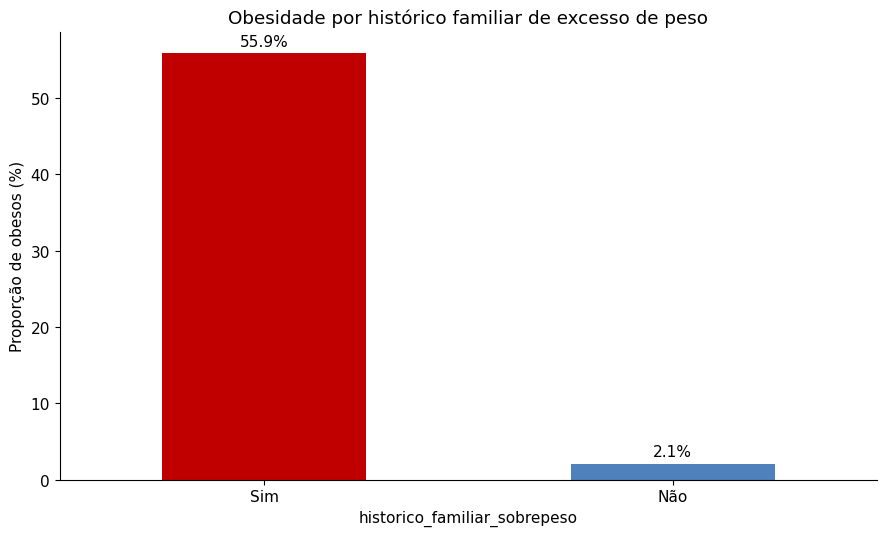

In [27]:
# Histórico familiar de Sobrepeso
family = df_tratado.groupby('historico_familiar_sobrepeso')['is_obeso'].mean()*100
fig, ax = plt.subplots()
family.reindex([1, 0]).rename({1:'Sim', 0:'Não'}).plot(kind='bar', ax=ax, color=['#C00000','#4F81BD'])
ax.set_title('Obesidade por histórico familiar de excesso de peso')
ax.set_ylabel('Proporção de obesos (%)')
for i,v in enumerate(family.reindex([1, 0]).values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
plt.xticks(rotation=0)
save_and_show(out/'05_family_history.png')

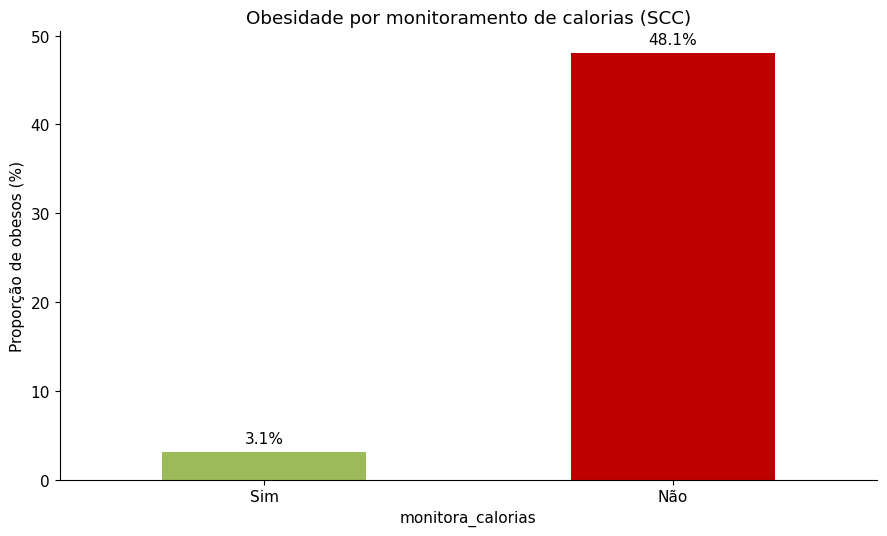

In [28]:
# Monitora Calorias
scc = df_tratado.groupby('monitora_calorias')['is_obeso'].mean()*100
fig, ax = plt.subplots()
scc.reindex([1, 0]).rename({1:'Sim', 0:'Não'}).plot(kind='bar', ax=ax, color=['#9BBB59','#C00000'])
ax.set_title('Obesidade por monitoramento de calorias (SCC)')
ax.set_ylabel('Proporção de obesos (%)')
for i,v in enumerate(scc.reindex([1, 0]).values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
plt.xticks(rotation=0)
save_and_show(out/'06_scc.png')

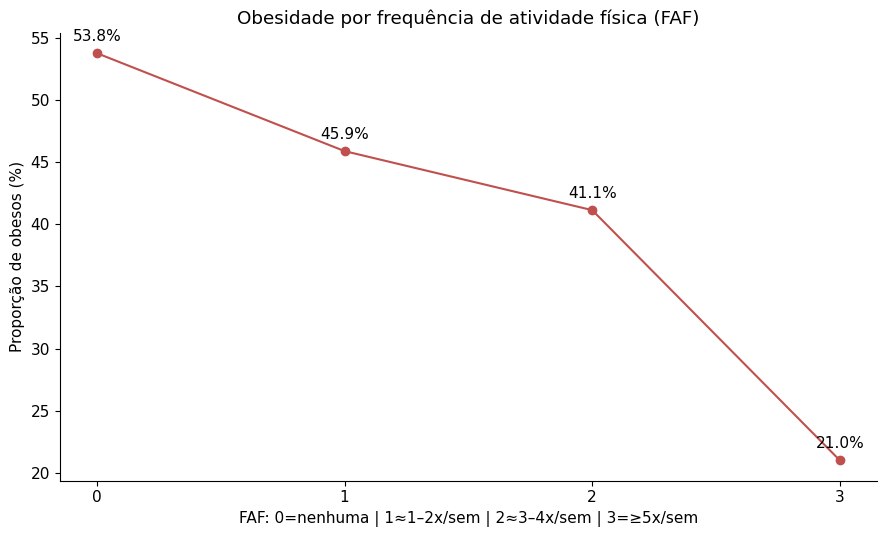

In [29]:
# Atividade Física Semanal
faf = df_tratado.groupby('atividade_fisica_semana')['is_obeso'].mean()*100
fig, ax = plt.subplots()
faf.sort_index().plot(kind='line', marker='o', ax=ax, color='#C0504D')
ax.set_title('Obesidade por frequência de atividade física (FAF)')
ax.set_xlabel('FAF: 0=nenhuma | 1≈1–2x/sem | 2≈3–4x/sem | 3=≥5x/sem')
ax.set_ylabel('Proporção de obesos (%)')
for x,y in faf.sort_index().items():
    ax.text(x, y+1, f"{y:.1f}%", ha='center')
ax.set_xticks([0,1,2,3])
save_and_show(out/'07_faf.png')

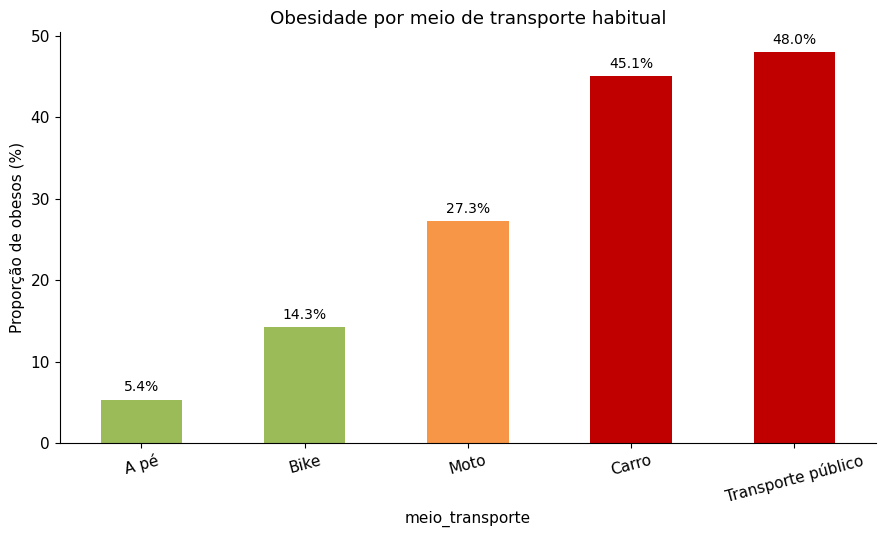

In [30]:
# Meio de Transporte
mtrans = df_tratado.groupby('meio_transporte')['is_obeso'].mean().sort_values(ascending=False)*100
order = ['Walking','Bike','Motorbike','Automobile','Public_Transportation']
fig, ax = plt.subplots()
mtrans.reindex(order).rename({'Walking':'A pé','Bike':'Bike','Motorbike':'Moto','Automobile':'Carro','Public_Transportation':'Transporte público'}).plot(kind='bar', ax=ax, color=['#9BBB59','#9BBB59','#F79646','#C00000','#C00000'])
ax.set_title('Obesidade por meio de transporte habitual')
ax.set_ylabel('Proporção de obesos (%)')
for i,v in enumerate(mtrans.reindex(order).values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center', fontsize=10)
plt.xticks(rotation=15)
save_and_show(out/'08_mtrans.png')

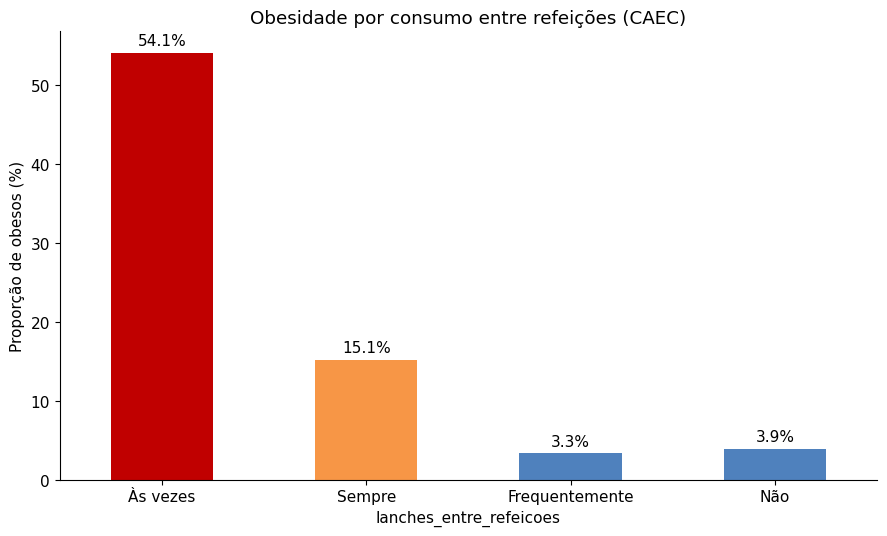

In [31]:
# Consumo de Lanches entre as refeiçõesz
caec = df_tratado.groupby('lanches_entre_refeicoes')['is_obeso'].mean()*100
order_caec = ['Sometimes','Always','Frequently','no']  # destacar atipicidades
fig, ax = plt.subplots()
caec.reindex(order_caec).rename({'Sometimes':'Às vezes','Always':'Sempre','Frequently':'Frequentemente','no':'Não'}).plot(kind='bar', ax=ax, color=['#C00000','#F79646','#4F81BD','#4F81BD'])
ax.set_title('Obesidade por consumo entre refeições (CAEC)')
ax.set_ylabel('Proporção de obesos (%)')
for i,v in enumerate(caec.reindex(order_caec).values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
plt.xticks(rotation=0)
save_and_show(out/'09_caec.png')

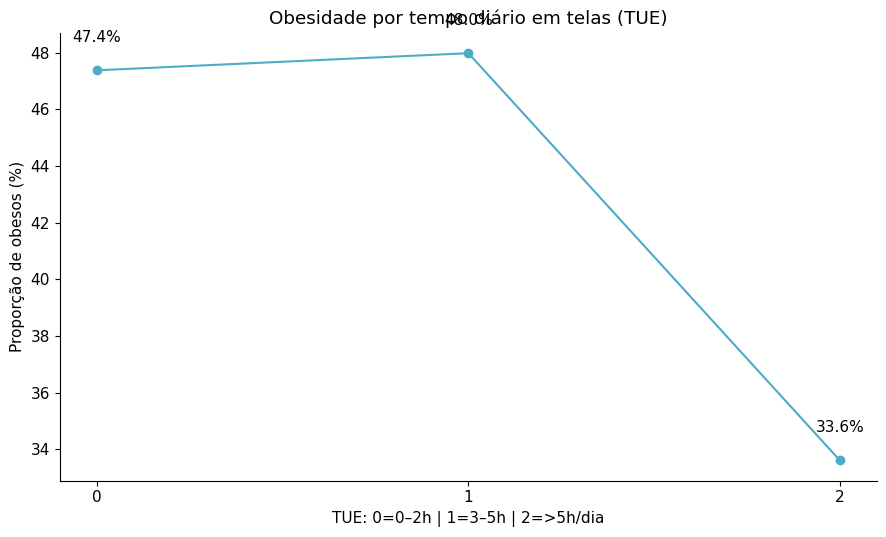

In [32]:
# Tempo de Tela por Dia
tue = df_tratado.groupby('tempo_eletronicos_por_dia')['is_obeso'].mean()*100
fig, ax = plt.subplots()
tue.sort_index().plot(kind='line', marker='o', ax=ax, color='#4BACC6')
ax.set_title('Obesidade por tempo diário em telas (TUE)')
ax.set_xlabel('TUE: 0=0–2h | 1=3–5h | 2=>5h/dia')
ax.set_ylabel('Proporção de obesos (%)')
for x,y in tue.sort_index().items():
    ax.text(x, y+1, f"{y:.1f}%", ha='center')
ax.set_xticks([0,1,2])
save_and_show(out/'10_tue.png')

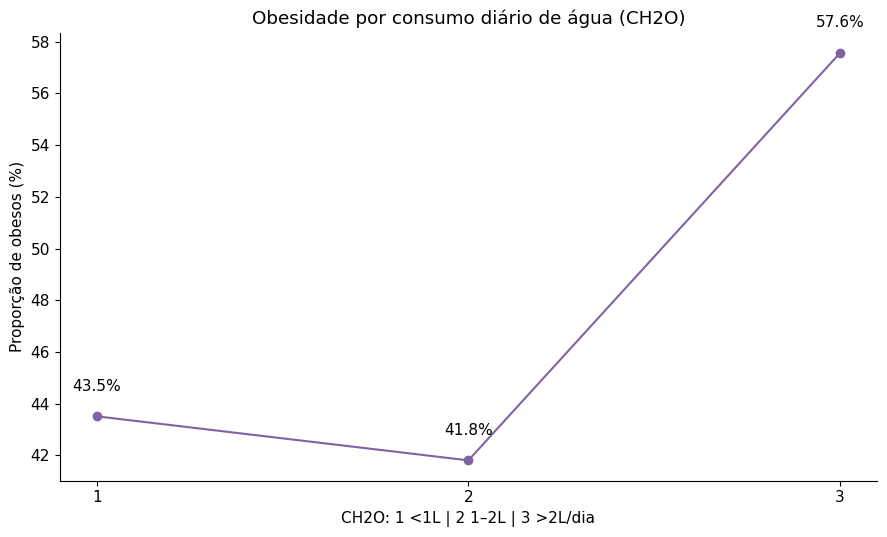

{'n_registros': 2111, 'overview_%': {'obesidade': 46.0, 'sobrepeso': 27.5, 'normal_abaixo': 26.5}, 'acordo_label_imc_%': 95.2, 'arquivos': ['01_distribuicao_geral.png', '02_acordo_rotulo_imc.png', '03_genero_obesidade_II_III.png', '03_genero_obesity_II_III.png', '04_favc.png', '05_family_history.png', '06_scc.png', '07_faf.png', '08_mtrans.png', '09_caec.png', '10_tue.png', '11_ch2o.png']}


In [33]:
# Consumo diário de água
ch2o = df_tratado.groupby('consumo_agua_por_dia')['is_obeso'].mean()*100
fig, ax = plt.subplots()
ch2o.sort_index().plot(kind='line', marker='o', ax=ax, color='#8064A2')
ax.set_title('Obesidade por consumo diário de água (CH2O)')
ax.set_xlabel('CH2O: 1 <1L | 2 1–2L | 3 >2L/dia')
ax.set_ylabel('Proporção de obesos (%)')
for x,y in ch2o.sort_index().items():
    ax.text(x, y+1, f"{y:.1f}%", ha='center')
ax.set_xticks([1,2,3])
save_and_show(out/'11_ch2o.png')

print({'n_registros': N,
       'overview_%': {'obesidade': round(P_obeso,1), 'sobrepeso': round(P_sobrepeso,1), 'normal_abaixo': round(P_normal,1)},
       'acordo_label_imc_%': round(agreement,1),
       'arquivos': sorted([p.name for p in out.glob('*.png')])})